In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import umap
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from modules.sparse_autoencoder import *
import pickle
import mygene
from tqdm import tqdm
from modules.deg_analysis import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-18 13:09:08.460802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 13:09:09.125998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load h5ad object
adata = anndata.read_h5ad("data/fede_count.h5ad")
# Map appropriate condition tags
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

# Load cell annotation info
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])
anno_df = anno_df.set_index('cell_id')[['class_name']]
anno_df.index = anno_df.index.astype('str')

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs['class_name'] = anno_df['class_name']

In [4]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=10)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#adata = adata[(adata.obs.pct_counts_mt < 60), :]
#adata = adata[:, ~adata.var['mt']]
#adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
#sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True, max_fraction=0.1)

In [212]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()
train_dataset = AnnDataDataset(adata_train)
test_dataset = AnnDataDataset(adata_test)
n_inputs = adata.var.index.values.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [213]:
autoencoder = Autoencoder(n_latents=50, 
                          n_inputs=n_inputs, 
                          activation=TopK(k=20), 
                          tied=True, 
                          normalize=True)
autoencoder.to(device)
train_autoencoder(autoencoder, 
                  train_loader, 
                  test_loader, 
                  num_epochs=50, 
                  learning_rate=0.0001, 
                  prune_interval=5, 
                  prune_amount=0.99)

100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.21it/s]


Epoch 1/50, Loss: 0.40604662895202637, Test Loss: 2.0155208711856165
Saved new best model with test loss: 2.0155208711856165


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.34it/s]


Epoch 2/50, Loss: 0.5012370944023132, Test Loss: 1.6172726854381945
Saved new best model with test loss: 1.6172726854381945


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.51it/s]


Epoch 3/50, Loss: 0.8384955525398254, Test Loss: 1.4025027028866262
Saved new best model with test loss: 1.4025027028866262


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 81.56it/s]


Epoch 4/50, Loss: 0.25000935792922974, Test Loss: 1.2666472426596904
Saved new best model with test loss: 1.2666472426596904


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 82.15it/s]


Pruning applied at epoch 5
Epoch 5/50, Loss: 1.2230522632598877, Test Loss: 1.5574307550719921


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 80.81it/s]


Epoch 6/50, Loss: 1.5907552242279053, Test Loss: 1.1142946011668085
Saved new best model with test loss: 1.1142946011668085


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.29it/s]


Epoch 7/50, Loss: 0.6465070247650146, Test Loss: 1.0691420367900157
Saved new best model with test loss: 1.0691420367900157


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.81it/s]


Epoch 8/50, Loss: 4.3425445556640625, Test Loss: 1.0565890492808898
Saved new best model with test loss: 1.0565890492808898


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.06it/s]


Epoch 9/50, Loss: 0.2149898111820221, Test Loss: 1.0141262102047068
Saved new best model with test loss: 1.0141262102047068


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.27it/s]


Pruning applied at epoch 10
Epoch 10/50, Loss: 1.104708194732666, Test Loss: 1.2975160770568273


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.30it/s]


Epoch 11/50, Loss: 1.682276725769043, Test Loss: 0.9753012336140511
Saved new best model with test loss: 0.9753012336140511


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.96it/s]


Epoch 12/50, Loss: 0.23469144105911255, Test Loss: 0.9602009135004658
Saved new best model with test loss: 0.9602009135004658


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.01it/s]


Epoch 13/50, Loss: 0.14278544485569, Test Loss: 0.9618092227302142


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.28it/s]


Epoch 14/50, Loss: 0.906164288520813, Test Loss: 0.9319311042360011
Saved new best model with test loss: 0.9319311042360011


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.87it/s]


Pruning applied at epoch 15
Epoch 15/50, Loss: 0.8166636228561401, Test Loss: 1.2378013458027937


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.26it/s]


Epoch 16/50, Loss: 0.607079267501831, Test Loss: 0.9408644871823739


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 76.35it/s]


Epoch 17/50, Loss: 0.32041001319885254, Test Loss: 0.9491476908626172


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 82.95it/s]


Epoch 18/50, Loss: 2.8652050495147705, Test Loss: 0.9782309736181426


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 82.66it/s]


Epoch 19/50, Loss: 0.4305226504802704, Test Loss: 0.935333196348792


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.20it/s]


Pruning applied at epoch 20
Epoch 20/50, Loss: 0.32151129841804504, Test Loss: 1.199062002285215


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.41it/s]


Epoch 21/50, Loss: 1.3162384033203125, Test Loss: 0.8998039767846165
Saved new best model with test loss: 0.8998039767846165


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.93it/s]


Epoch 22/50, Loss: 2.1830880641937256, Test Loss: 0.8942089111812963
Saved new best model with test loss: 0.8942089111812963


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.48it/s]


Epoch 23/50, Loss: 7.008236408233643, Test Loss: 0.8906748696861652
Saved new best model with test loss: 0.8906748696861652


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.47it/s]


Epoch 24/50, Loss: 0.7349847555160522, Test Loss: 0.8843401287426085
Saved new best model with test loss: 0.8843401287426085


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.53it/s]


Pruning applied at epoch 25
Epoch 25/50, Loss: 0.5947973728179932, Test Loss: 1.1636641233559424


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.47it/s]


Epoch 26/50, Loss: 0.5602653622627258, Test Loss: 0.8792568666222912
Saved new best model with test loss: 0.8792568666222912


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.87it/s]


Epoch 27/50, Loss: 0.7314773201942444, Test Loss: 0.9239230768992597


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.66it/s]


Epoch 28/50, Loss: 0.33040475845336914, Test Loss: 0.8614683606280576
Saved new best model with test loss: 0.8614683606280576


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.01it/s]


Epoch 29/50, Loss: 0.2651101350784302, Test Loss: 0.8597032537796353
Saved new best model with test loss: 0.8597032537796353


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.52it/s]


Pruning applied at epoch 30
Epoch 30/50, Loss: 1.2294102907180786, Test Loss: 1.1275517772508148


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.65it/s]


Epoch 31/50, Loss: 0.42973238229751587, Test Loss: 0.8562641696841925
Saved new best model with test loss: 0.8562641696841925


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.60it/s]


Epoch 32/50, Loss: 0.4235813319683075, Test Loss: 0.8535523908650315
Saved new best model with test loss: 0.8535523908650315


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.68it/s]


Epoch 33/50, Loss: 0.44222062826156616, Test Loss: 0.8471281656482875
Saved new best model with test loss: 0.8471281656482875


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.91it/s]


Epoch 34/50, Loss: 0.8514078259468079, Test Loss: 0.8496292699503418


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.60it/s]


Pruning applied at epoch 35
Epoch 35/50, Loss: 0.5147103667259216, Test Loss: 1.0962144794480113


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.36it/s]


Epoch 36/50, Loss: 0.779396653175354, Test Loss: 0.8437812401344312
Saved new best model with test loss: 0.8437812401344312


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.77it/s]


Epoch 37/50, Loss: 0.4153669774532318, Test Loss: 0.8350489230563977
Saved new best model with test loss: 0.8350489230563977


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.02it/s]


Epoch 38/50, Loss: 0.849921464920044, Test Loss: 0.8261841072532154
Saved new best model with test loss: 0.8261841072532154


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.31it/s]


Epoch 39/50, Loss: 0.47462403774261475, Test Loss: 0.8474440547643892


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 81.99it/s]


Pruning applied at epoch 40
Epoch 40/50, Loss: 0.4345378875732422, Test Loss: 1.0699807050444137


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.31it/s]


Epoch 41/50, Loss: 0.46415001153945923, Test Loss: 0.8259663697857185
Saved new best model with test loss: 0.8259663697857185


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 82.85it/s]


Epoch 42/50, Loss: 0.3666834831237793, Test Loss: 0.8144011821522809
Saved new best model with test loss: 0.8144011821522809


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.20it/s]


Epoch 43/50, Loss: 0.2858477532863617, Test Loss: 0.8096312972523222
Saved new best model with test loss: 0.8096312972523222


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 82.92it/s]


Epoch 44/50, Loss: 1.392574429512024, Test Loss: 0.8054391807757768
Saved new best model with test loss: 0.8054391807757768


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 83.73it/s]


Pruning applied at epoch 45
Epoch 45/50, Loss: 0.3270575702190399, Test Loss: 1.0449309795094817


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 85.35it/s]


Epoch 46/50, Loss: 0.6249510645866394, Test Loss: 0.8047221242981469
Saved new best model with test loss: 0.8047221242981469


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.40it/s]


Epoch 47/50, Loss: 0.1791898012161255, Test Loss: 0.8106004674762688


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.03it/s]


Epoch 48/50, Loss: 0.26680052280426025, Test Loss: 0.800975028000422
Saved new best model with test loss: 0.800975028000422


100%|█████████████████████████████████████████| 595/595 [00:07<00:00, 84.12it/s]


Epoch 49/50, Loss: 1.8374062776565552, Test Loss: 0.7949457722622276
Saved new best model with test loss: 0.7949457722622276


100%|█████████████████████████████████████████| 595/595 [00:06<00:00, 86.55it/s]


Pruning applied at epoch 50
Epoch 50/50, Loss: 2.910243511199951, Test Loss: 1.029995974778329


In [215]:
autoencoder = Autoencoder(n_latents=50, n_inputs=n_inputs, activation=TopK(k=20), tied=True, normalize=True).to(device)
state_dict = torch.load('best_autoencoder.pth')
model_state_dict = autoencoder.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
autoencoder.load_state_dict(filtered_state_dict, strict=False)
autoencoder.eval()
autoencoder.cpu()
apply_pruning(autoencoder, amount=0.99)

Autoencoder(
  (encoder): Linear(in_features=29015, out_features=50, bias=False)
  (activation): TopK(
    (postact_fn): ReLU()
  )
  (decoder): TiedTranspose(
    (linear): Linear(in_features=29015, out_features=50, bias=False)
  )
)

# UMAP

In [ ]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)

In [218]:
latents, _ = autoencoder.encode(data)
latents_np = latents.detach().numpy()
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(latents_np)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [445]:
scaler = MinMaxScaler((0, 1))
array1 = adata_test.obs['Sample_Tag'].values
array2 = scaler.fit_transform(latents_np)
df = pd.DataFrame({'Sample_Tag': array1, **dict(zip(range(array2.shape[1]), array2.T))})
df = df.groupby('Sample_Tag').mean().loc[:, df.ne(0).any()]
mean_values = df.mean()
df = df[mean_values.sort_values(ascending=False).index]

# Top contributing genes for each latent dimension

In [418]:
top_genes = get_top_genes(autoencoder, adata, top_n=500)

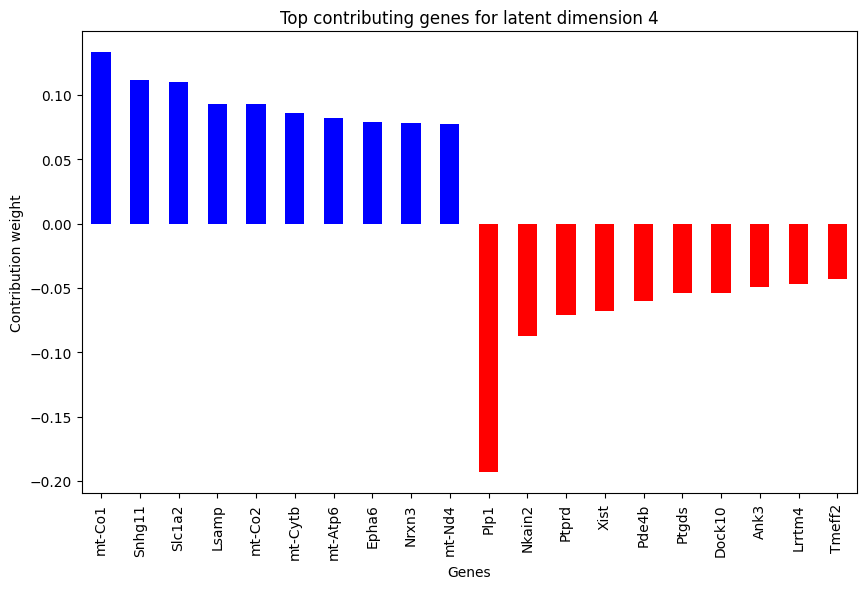

In [464]:
plot_top_contributing_genes(autoencoder, adata_test, latent_dim=4, top_n=10)

# GO term enrichment analysis

In [262]:
genes_ncbi = query_genes(adata)

3117 input query terms found dup hits:	[('0610006L08RIK', 2), ('0610025J13RIK', 2), ('0610033M10RIK', 2), ('0710001A04RIK', 2), ('1010001B2
2502 input query terms found no hit:	['0610009B22RIK', '0610012G03RIK', '1110017D15RIK', '1110032A03RIK', '1190007I07RIK', '1520401A03RIK


In [370]:
all_df_results = []
for i in tqdm(range(5)):
    gene_ids = [int(genes_ncbi[x.upper()]) for x in top_genes[i] if x.upper() in genes_ncbi.keys()]
    df_results = perform_go_enrichment(gene_ids, [int(x) for x in genes_ncbi.values()])
    all_df_results.append(df_results)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.965599 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,849 of 23,652 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,678 of 23,652 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,052 of 23,652 population items found in association

Runing BP Ontology Analysis: current study set of 27 IDs.
 81%     22 of     27 study items found in association
100%     27 of     27 study items found in population(23652)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,849 of 23,652 population items
     225 terms are associated with     22 of     27 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO I

 20%|█████████                                    | 1/5 [00:49<03:16, 49.08s/it]

   4,578 terms are associated with 15,052 of 23,652 population items
      76 terms are associated with     21 of     27 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:42.363755 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,849 of 23,652 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,678 of 23,652 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,052 of 23,652 population items found in association

Runing BP Ontology Analysis: current study set of 204 IDs.
 93%    190 of    204 study items found in association
100%    204 of    204 study items found in p

 40%|██████████████████                           | 2/5 [01:37<02:25, 48.53s/it]

   4,578 terms are associated with 15,052 of 23,652 population items
     356 terms are associated with    178 of    204 study items
  METHOD fdr_bh:
      44 GO terms found significant (< 0.05=alpha) ( 44 enriched +   0 purified): statsmodels fdr_bh
     141 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms


 40%|██████████████████                           | 2/5 [02:10<03:16, 65.41s/it]


KeyboardInterrupt: 

In [265]:
with open('all_df_results.pkl', 'wb') as f:
    pickle.dump(all_df_results, f)

with open('all_df_results.pkl', 'rb') as f:
    all_df_results = pickle.load(f)

In [ ]:
dim=32
#BP CC or MF
display_go_enrichment(all_df_results[dim], f'latent_dim_{dim}', namespace='BP')

In [452]:
dim=4

In [453]:
pos_gene_ids = [int(genes_ncbi[x.upper()]) for x in top_genes[dim]['positive'] if x.upper() in genes_ncbi.keys()]
pos_df_results = perform_go_enrichment(pos_gene_ids, [int(x) for x in genes_ncbi.values()])

neg_gene_ids = [int(genes_ncbi[x.upper()]) for x in top_genes[dim]['negative'] if x.upper() in genes_ncbi.keys()]
neg_df_results = perform_go_enrichment(neg_gene_ids, [int(x) for x in genes_ncbi.values()])

DEG/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
HMS:0:00:41.954284 440,141 annotations, 29,889 genes, 18,966 GOs, 1 taxids READ: DEG/gene2go 

Load BP Ontology Enrichment Analysis ...
 67% 15,849 of 23,652 population items found in association

Load CC Ontology Enrichment Analysis ...
 71% 16,678 of 23,652 population items found in association

Load MF Ontology Enrichment Analysis ...
 64% 15,052 of 23,652 population items found in association

Runing BP Ontology Analysis: current study set of 146 IDs.
 90%    131 of    146 study items found in association
100%    146 of    146 study items found in population(23652)
Calculating 12,391 uncorrected p-values using fisher_scipy_stats
  12,391 terms are associated with 15,849 of 23,652 population items
   1,458 terms are associated with    131 of    146 study items
  METHOD fdr_bh:
      40 GO terms found significant (< 0.05=alpha) ( 40 enriched +   0 purified): statsmodels fdr_bh
      84 study items associated with significant GO 

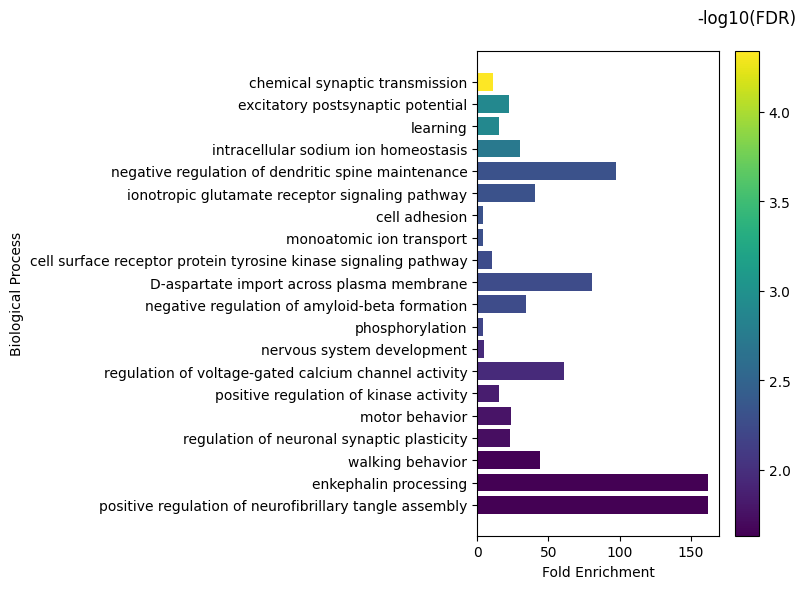

In [463]:
display_go_enrichment(pos_df_results, f'latent_dim_{dim}', namespace='BP')

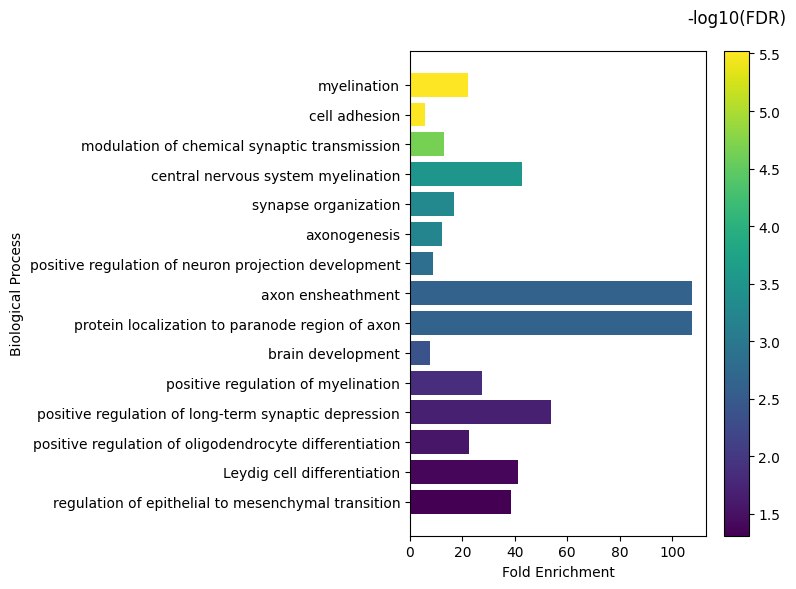

In [462]:
display_go_enrichment(neg_df_results, f'latent_dim_{dim}', namespace='BP')

# Latent dimensions heatmap

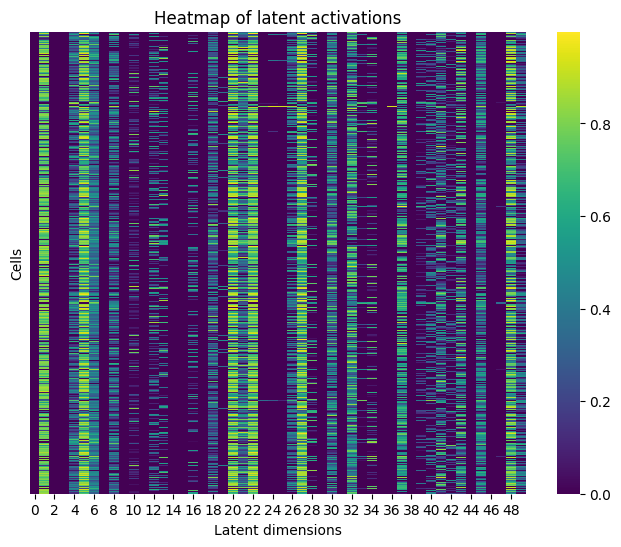

In [246]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_5xFAD', 'LD_NC', 'run_5xFAD', 'run_NC'])

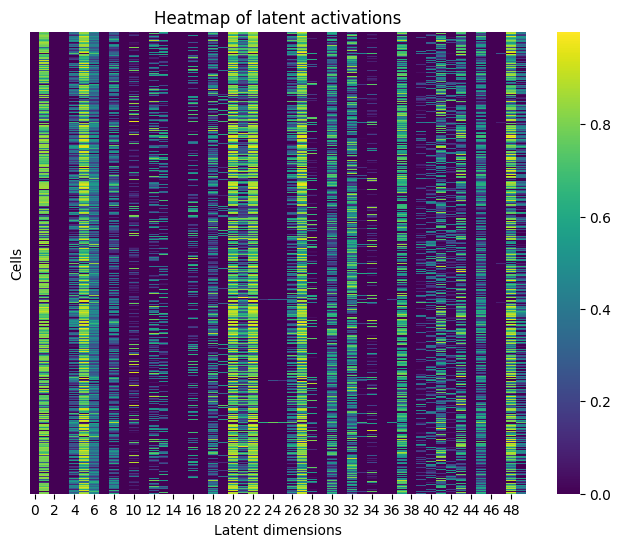

In [247]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_5xFAD'])

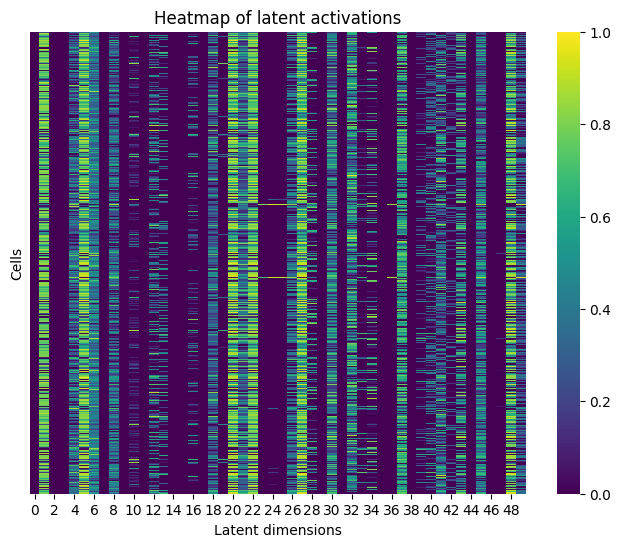

In [248]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["LD_NC"])

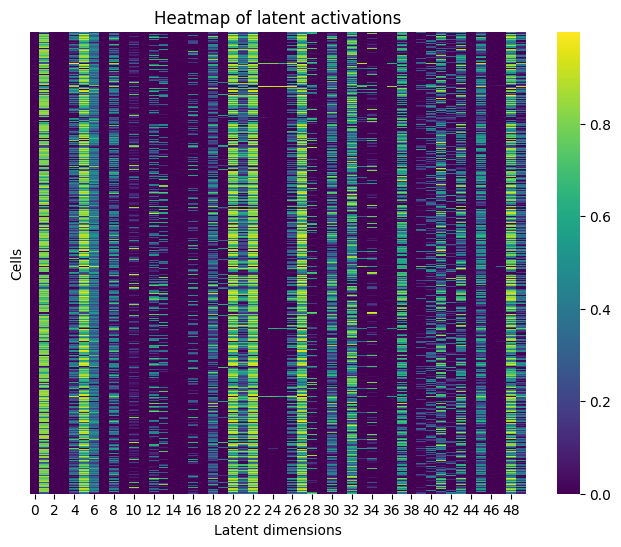

In [249]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['run_5xFAD'])

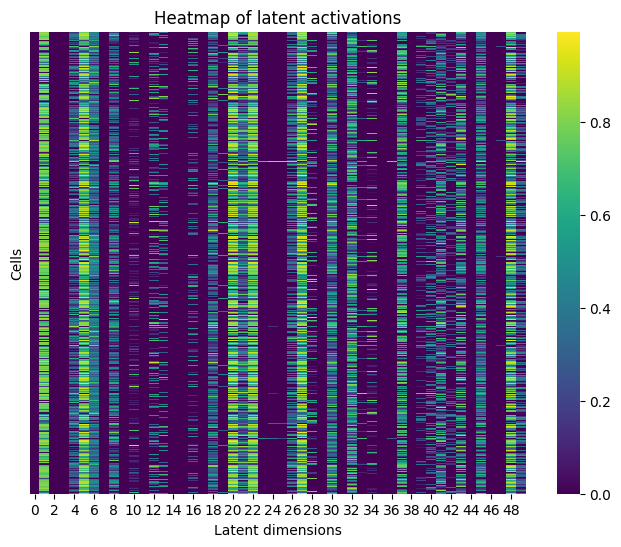

In [250]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=["run_NC"])

# Visualize embedding

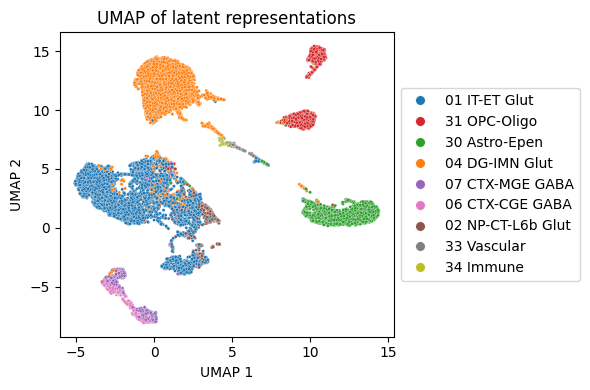

In [251]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC', 'run_5xFAD', 'run_NC', 'LD_5xFAD'], min_count=50)

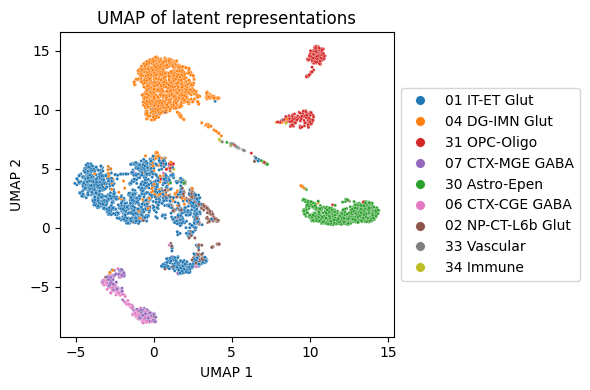

In [252]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_NC'], min_count=50)

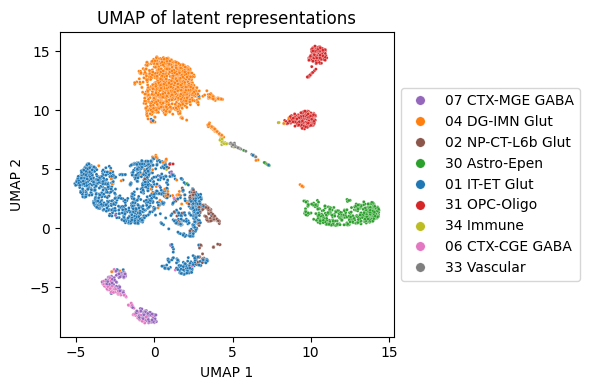

In [253]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_5xFAD'], min_count=50)

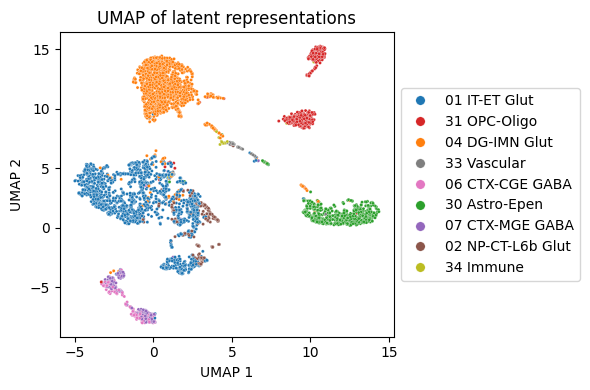

In [254]:
plot_umap_embedding(embedding, adata_test, sample_tags=['run_NC'], min_count=50)

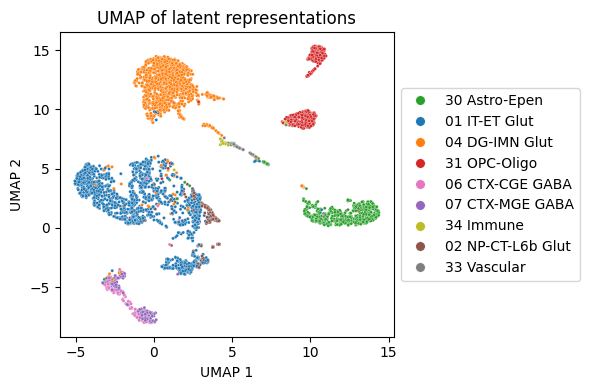

In [255]:
plot_umap_embedding(embedding, adata_test, sample_tags=['LD_5xFAD'], min_count=50)

# Plot reconstructions

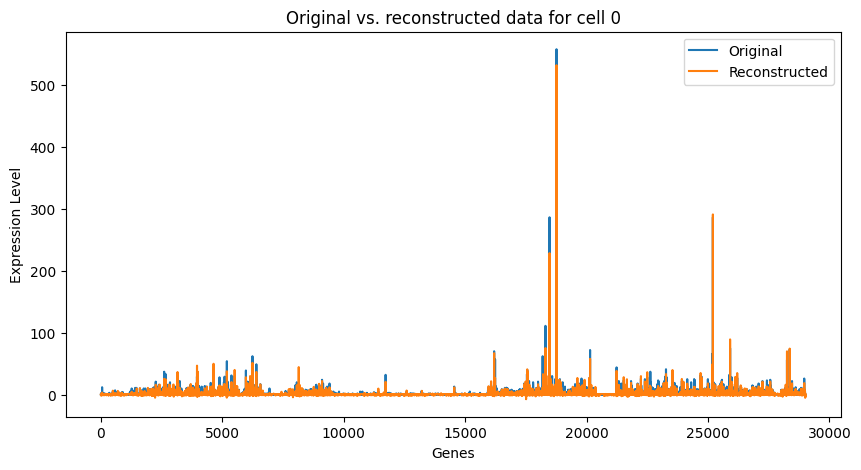

In [75]:
plot_cell_reconstruction(autoencoder, data, cell_idx=0)

In [ ]:
plot_gene_reconstruction(autoencoder, data, gene_idx=0)